<a href="https://colab.research.google.com/github/nilesh2gupta/UBC_project/blob/main/Combining_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spacy networkx
!pip install spacy spacy-entity-linker wikipedia-api
!pip install mwparserfromhell
!pip install wptools
!pip install torch_geometric

#Knowledge Entities Formation

In [2]:
import spacy
import requests
import wptools
import networkx as nx
import matplotlib.pyplot as plt
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import numpy as np
import wikipediaapi
import re

nlp = spacy.load("en_core_web_sm")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

class KnowledgeGraphBuilder:
    def __init__(self, news_text):
        self.news_text = news_text
        self.coarse_graph = None
        self.fine_graph = None
        self.node_to_idx_coarse = {}
        self.node_to_idx_fine = {}

    def get_wikipedia_url(self, entity):
        url = f"https://en.wikipedia.org/wiki/{entity.replace(' ', '_')}"
        return url

    def fetch_wikipedia_summary(self, topic):
        wiki = wikipediaapi.Wikipedia('MyWikiFetcher/1.0 (nilegupta2001@gmail.com)')
        page = wiki.page(topic)
        if page.exists():
            return page.summary
        return None

    def augment_news_with_entities(self, news_text, entity_summaries):
        augmented_text = news_text
        for entity, summary in entity_summaries.items():
            if summary:
                augmented_text += f"\n{entity}: {summary}"
        return augmented_text

    def get_infobox(self, title, limit=20):
        try:
            page = wptools.page(title)
            page.get_parse()
            infobox = page.data.get('infobox')
            if infobox:
                values = list(infobox.values())[:limit]
                cleaned_values = [re.sub(r'\W+', ' ', str(value)).strip() for value in values]
                return cleaned_values
            return None
        except Exception as e:
            print(f"An error occurred: {e}")
            return None

    def get_roberta_embeddings(self, text):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

    def build_coarse_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.coarse_graph = nx.Graph()
            return

        coarse_grained_summaries = {entity: self.fetch_wikipedia_summary(entity) for entity, label in entities}
        augmented_news_coarse = self.augment_news_with_entities(self.news_text, coarse_grained_summaries)
        doc_coarse = nlp(augmented_news_coarse)
        entities_coarse = [(ent.text, ent.label_) for ent in doc_coarse.ents]
        linked_entities_coarse = {entity: self.get_wikipedia_url(entity) for entity, label in entities_coarse}

        G_coarse = nx.Graph()

        for entity, url in linked_entities_coarse.items():
            embedding = self.get_roberta_embeddings(entity)
            G_coarse.add_node(entity, url=url, embedding=embedding)

        for sent in doc_coarse.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_coarse.has_node(entity1) and G_coarse.has_node(entity2):
                        G_coarse.add_edge(entity1, entity2)

        self.coarse_graph = G_coarse

    def build_fine_graph(self):
        doc = nlp(self.news_text)
        entities = [(ent.text, ent.label_) for ent in doc.ents]

        if not entities:
            print("No entities found in the news text.")
            self.fine_graph = nx.Graph()
            return

        fine_grained_infoboxes = {entity: self.get_infobox(entity) for entity, label in entities}
        augmented_news_fine = self.augment_news_with_entities(self.news_text, fine_grained_infoboxes)
        pattern = r'[\|\[\]]'
        augmented_news_fine = re.sub(pattern, '', augmented_news_fine)
        doc_fine = nlp(augmented_news_fine)
        entities_fine = [(ent.text, ent.label_) for ent in doc_fine.ents]
        linked_entities_fine = {entity: self.get_wikipedia_url(entity) for entity, label in entities_fine}

        G_fine = nx.Graph()

        for entity, url in linked_entities_fine.items():
            embedding = self.get_roberta_embeddings(entity)
            G_fine.add_node(entity, url=url, embedding=embedding)

        for sent in doc_fine.sents:
            sent_entities = [ent.text for ent in sent.ents]
            for i, entity1 in enumerate(sent_entities):
                for entity2 in sent_entities[i+1:]:
                    if G_fine.has_node(entity1) and G_fine.has_node(entity2):
                        G_fine.add_edge(entity1, entity2)

        self.fine_graph = G_fine

    def convert_to_pytorch_geometric(self):
        if not self.coarse_graph or not self.fine_graph:
            return None, None

        self.node_to_idx_coarse = {node: idx for idx, node in enumerate(self.coarse_graph.nodes())}
        edge_list_coarse = nx.to_edgelist(self.coarse_graph)
        edge_index_coarse = torch.tensor([[self.node_to_idx_coarse[u], self.node_to_idx_coarse[v]] for u, v, _ in edge_list_coarse], dtype=torch.long).t().contiguous()
        node_features_coarse = np.array([node[1]['embedding'] for node in self.coarse_graph.nodes(data=True)])
        node_features_coarse = torch.tensor(node_features_coarse, dtype=torch.float)

        self.node_to_idx_fine = {node: idx for idx, node in enumerate(self.fine_graph.nodes())}
        edge_list_fine = nx.to_edgelist(self.fine_graph)
        edge_index_fine = torch.tensor([[self.node_to_idx_fine[u], self.node_to_idx_fine[v]] for u, v, _ in edge_list_fine], dtype=torch.long).t().contiguous()
        node_features_fine = np.array([node[1]['embedding'] for node in self.fine_graph.nodes(data=True)])
        node_features_fine = torch.tensor(node_features_fine, dtype=torch.float)

        data_coarse = Data(x=node_features_coarse, edge_index=edge_index_coarse)
        data_fine = Data(x=node_features_fine, edge_index=edge_index_fine)

        return data_coarse, data_fine

class GATModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_heads):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_dim, hidden_dim, heads=num_heads, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * num_heads, out_dim, heads=1, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

def train_gat_model(model, data, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}')
    return model

def get_contextual_representations(news_text):
    kg_builder = KnowledgeGraphBuilder(news_text)
    kg_builder.build_coarse_graph()
    kg_builder.build_fine_graph()
    data_coarse, data_fine = kg_builder.convert_to_pytorch_geometric()

    if data_coarse is None or data_fine is None:
        print("Graph data is not available due to lack of entities.")
        return None, None

    in_dim = data_coarse.x.shape[1]
    hidden_dim = 96
    out_dim = 768
    num_heads = 8

    model = GATModel(in_dim, hidden_dim, out_dim, num_heads)

    # Train the model (you may need to adjust the number of epochs and learning rate)
    model = train_gat_model(model, data_coarse, epochs=100, lr=0.001)
    model = train_gat_model(model, data_fine, epochs=100, lr=0.001)

    # Get the contextual representations
    model.eval()
    with torch.no_grad():
        contextual_vectors_coarse = model(data_coarse)
        contextual_vectors_fine = model(data_fine)

    return contextual_vectors_coarse, contextual_vectors_fine


# Plot the graphs side by side
def plot_graphs(kg_builder):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Coarse-grained graph
    pos_coarse = nx.circular_layout(kg_builder.coarse_graph)
    nx.draw(kg_builder.coarse_graph, pos_coarse, with_labels=True, node_size=500, node_color="lightblue", font_size=10, ax=ax1)
    ax1.set_title("Coarse-Grained Knowledge Graph")

    # Fine-grained graph
    pos_fine = nx.circular_layout(kg_builder.fine_graph)
    nx.draw(kg_builder.fine_graph, pos_fine, with_labels=True, node_size=500, node_color="lightgreen", font_size=10, ax=ax2)
    ax2.set_title("Fine-Grained Knowledge Graph")

    plt.show()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Model Architecture

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 roberta_with_adapter_1 (Ro  (None, None, 768)            1247447   ['input_ids[0][0]',           
 bertaWithAdapter)                                        68         'attention_mask[0][0]']      
                                                                                              

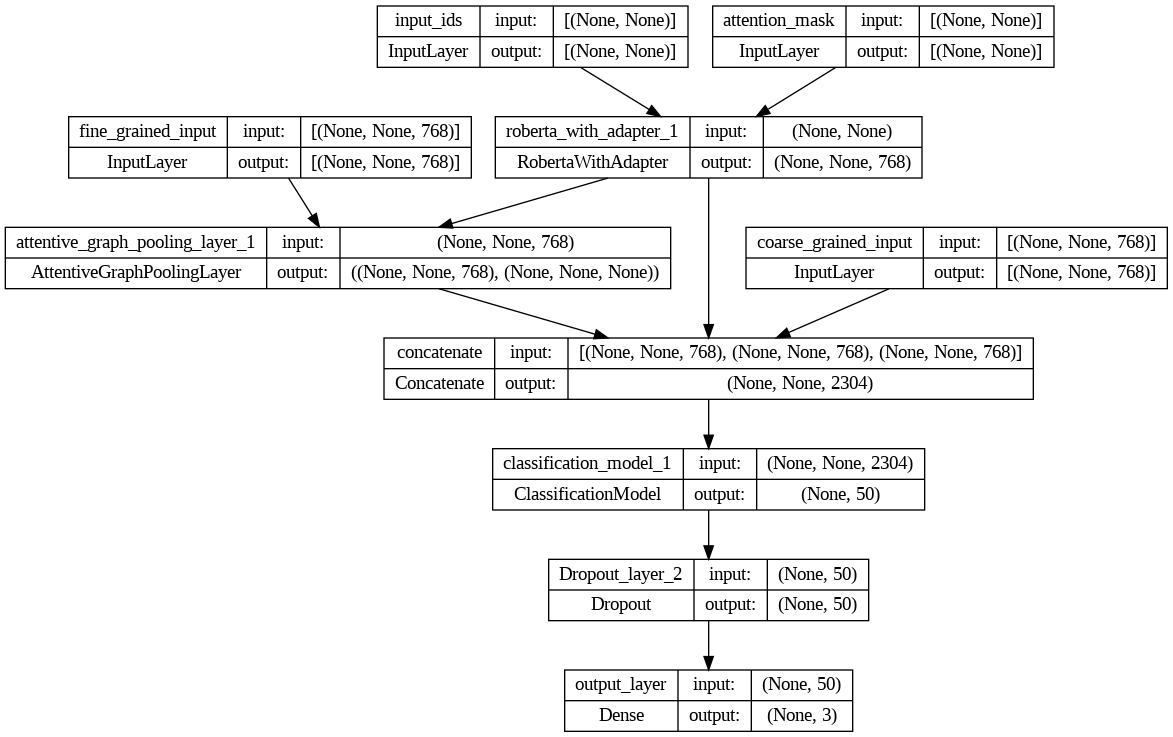

In [11]:
import tensorflow as tf
from transformers import TFRobertaModel, RobertaTokenizer
from tensorflow import keras
from keras.layers import Input, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPooling1D, Concatenate
from keras.models import Model
from keras.optimizers import Nadam
from keras.utils import plot_model

model_name = 'roberta-base'
tokenizer = RobertaTokenizer.from_pretrained(model_name)

class ClassificationModel(tf.keras.Model):
    def __init__(self, max_sequence_length, combined_embedding_dim):
        super(ClassificationModel, self).__init__()
        self.conv1d = Conv1D(filters=256, kernel_size=5, activation='relu', name='Conv1D_layer')
        self.max_pooling = MaxPooling1D(pool_size=2, name='MaxPooling_layer')
        self.bilstm = Bidirectional(LSTM(100, return_sequences=True), name='BiLSTM_layer')
        self.attention = tf.keras.layers.Attention(name='Attention_layer')
        self.global_max_pooling = GlobalMaxPooling1D(name='Attention_Pooling_layer')
        self.dense1 = Dense(100, activation='relu', name='Dense_layer_1')
        self.dropout1 = Dropout(0.6, name='Dropout_layer_1')
        self.dense2 = Dense(50, activation='relu', name='Dense_layer_2')

    def call(self, inputs):
        x = self.conv1d(inputs)
        x = self.max_pooling(x)
        x = self.bilstm(x)
        attention_output = self.attention([x, x])
        x = self.global_max_pooling(attention_output)
        x = self.dense1(x)
        x = self.dropout1(x)
        x = self.dense2(x)
        return x

class AdapterLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, adapter_dim):
        super(AdapterLayer, self).__init__()
        self.linear1 = tf.keras.layers.Dense(adapter_dim, activation='relu')
        self.linear2 = tf.keras.layers.Dense(input_dim)

    def call(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

class RobertaWithAdapter(tf.keras.Model):
    def __init__(self, model_name, adapter_dim):
        super(RobertaWithAdapter, self).__init__()
        self.roberta = TFRobertaModel.from_pretrained(model_name)
        self.adapter = AdapterLayer(self.roberta.config.hidden_size, adapter_dim)

    def call(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        adapter_output = self.adapter(sequence_output)
        return adapter_output

class AttentiveGraphPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_dim):
        super(AttentiveGraphPoolingLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.WQ = tf.keras.layers.Dense(hidden_dim)
        self.WK = tf.keras.layers.Dense(hidden_dim)
        self.WV = tf.keras.layers.Dense(hidden_dim)

    def call(self, h, c):
        Q = self.WQ(h)
        K = self.WK(c)
        V = self.WV(c)

        attn_scores = tf.matmul(Q, K, transpose_b=True)
        attn_scores = attn_scores / tf.math.sqrt(tf.cast(self.hidden_dim, tf.float32))

        attn_weights = tf.nn.softmax(attn_scores, axis=-1)
        attended_values = tf.matmul(attn_weights, V)

        return attended_values, attn_weights

input_ids = Input(shape=(None,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(None,), dtype=tf.int32, name='attention_mask')
fine_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='fine_grained_input')
coarse_grained_input = Input(shape=(None, 768), dtype=tf.float32, name='coarse_grained_input')

roberta_with_adapter = RobertaWithAdapter(model_name, adapter_dim=64)
attention_layer = AttentiveGraphPoolingLayer(hidden_dim=768)
max_seq = roberta_with_adapter.roberta.config.max_position_embeddings
class_model = ClassificationModel(max_sequence_length=max_seq, combined_embedding_dim=768)

roberta_output = roberta_with_adapter(input_ids=input_ids, attention_mask=attention_mask)
attention_output, _ = attention_layer(fine_grained_input, roberta_output)

concatenated_input = Concatenate()([roberta_output, attention_output, coarse_grained_input])

output_layer = class_model(concatenated_input)
dropout2 = Dropout(0.5, name='Dropout_layer_2')(output_layer)
output_layer = Dense(3, activation='softmax', name='output_layer')(dropout2)

final_model = Model(inputs=[input_ids, attention_mask, fine_grained_input, coarse_grained_input], outputs=output_layer)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
final_model.compile(optimizer=Nadam(learning_rate=0.001), loss=loss_fn, metrics=['accuracy'])

final_model.summary()
plot_model(final_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [12]:
def get_input(input_text, model, tokenizer):
    roberta_input = tokenizer(input_text, return_tensors='tf', truncation=True, padding=True)
    contextual_vectors_coarse, contextual_vectors_fine = get_contextual_representations(input_text)
    return roberta_input, contextual_vectors_coarse, contextual_vectors_fine

In [ ]:
input_text = "Microsoft is world's largest software comapny"
roberta_input ,contextual_vectors_coarse , contextual_vectors_fine = get_input(input_text , model , tokenizer)
print(roberta_input)
print(contextual_vectors_coarse)
print(contextual_vectors_fine)

In [14]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/UBC_project/cleaned_data_no_special_characters.csv' ,encoding='utf-8')
df.sample(10)

,claims,claims_labels
7529,when President Plump pull the United States ou...,REFUTES
406,accord to the WHO exposure to articulate matte...,SUPPORTS
9727,Microbes be we Gets not ignore this crisis any...,REFUTES
2839,it be one of the most important determining of...,NOT_ENOUGH_INFO
2673,animal husbandry be also responsible for green...,NOT_ENOUGH_INFO
7405,the effort be both urgent and extremely challe...,SUPPORTS
3202,the state produce about 75 of the phosphates r...,NOT_ENOUGH_INFO
4502,the most deadly heat wave in the history of Pa...,NOT_ENOUGH_INFO
1079,in the last 35 year of global warming the sun ...,SUPPORTS
3154,accord to the historical temperature record of...,SUPPORTS


In [15]:
df = df[(df['claims'].str.split().str.len() > 3) & (df['claims'].str.split().str.len() < 20)]
df.shape

(3850, 2)

Balanced Class Distribution:
claims_labels
SUPPORTS           1099
NOT_ENOUGH_INFO    1099
REFUTES            1099
Name: count, dtype: int64


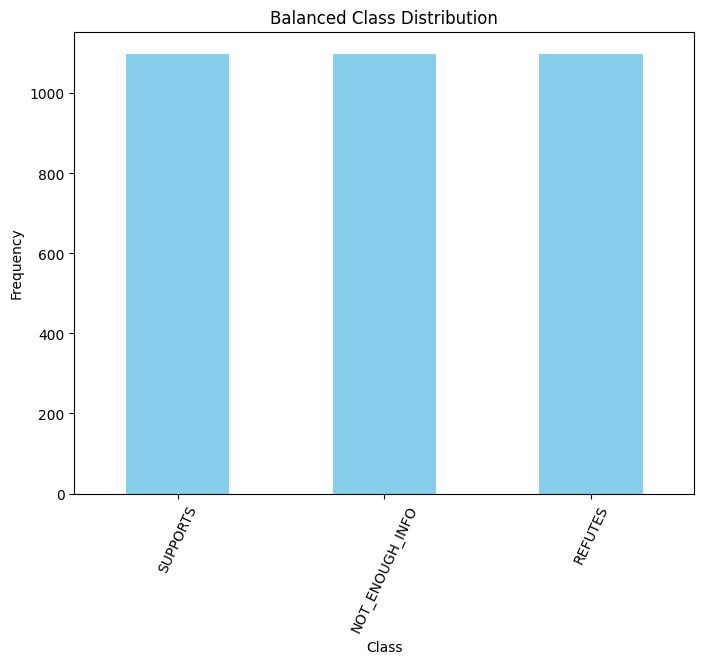

In [16]:
import matplotlib.pyplot as plt
min_class_size = min(df['claims_labels'].value_counts())

balanced_train_data = pd.DataFrame(columns=['claims','claims_labels'])

class_distribution = df['claims_labels'].value_counts()

for genre, count in class_distribution.items():
  class_data = df[df['claims_labels'] == genre].sample(n=min_class_size, random_state=22)
  balanced_train_data = pd.concat([balanced_train_data, class_data], ignore_index=True)

balanced_train_data.describe()
balanced_class_distribution = balanced_train_data['claims_labels'].value_counts()

print("Balanced Class Distribution:")
print(balanced_class_distribution)

plt.figure(figsize=(8, 6))
balanced_class_distribution.plot(kind='bar', color='skyblue')
plt.title('Balanced Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=65)
plt.show()

df = balanced_train_data


In [17]:
def ohe(text):

    if text=='SUPPORTS':
         return 2
    elif text=='NOT_ENOUGH_INFO':
         return 1
    elif text=='REFUTES' :
          return 0
    return 0

df['claims_labels']=df['claims_labels'].apply(lambda x:ohe(x))

df=df.sample(n=700,random_state=22)
df.shape

(700, 2)

In [18]:
def create_input_df(df, tokenizer, model):
  input_ids = []
  attention_masks = []
  contextual_vectors_coarse_list = []
  contextual_vectors_fine_list = []
  labels = []

  for index, row in df.iterrows():
    text = row['claims']
    label = row['claims_labels']
    roberta_input, contextual_vectors_coarse, contextual_vectors_fine = get_input(text, model, tokenizer)
    input_ids.append(roberta_input['input_ids'])
    attention_masks.append(roberta_input['attention_mask'])
    contextual_vectors_coarse_list.append(contextual_vectors_coarse)
    contextual_vectors_fine_list.append(contextual_vectors_fine)
    labels.append(label)

  input_df = pd.DataFrame({
      'input_ids': input_ids,
      'attention_mask': attention_masks,
      'contextual_vectors_coarse': contextual_vectors_coarse_list,
      'contextual_vectors_fine': contextual_vectors_fine_list,
      'labels': labels
  })

  return input_df


In [ ]:
df = create_input_df(df, tokenizer, model)
df.head()

No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.


en.wikipedia.org (parse) summer
en.wikipedia.org (imageinfo) File:Field Hamois Belgium Luc Viatour.jpg
Summer (en) data
{
  image: <list(1)> {'kind': 'parse-image', 'file': 'File:Field Ham...
  infobox: <dict(9)> title, image, caption, ndate1, ndate2, ndate3...
  iwlinks: <list(3)> https://commons.wikimedia.org/wiki/Summer, ht...
  pageid: 29392
  parsetree: <str(24387)> <root><template><title>pp-move-indef</ti...
  requests: <list(2)> parse, imageinfo
  title: Summer
  wikibase: Q1313
  wikidata_url: https://www.wikidata.org/wiki/Q1313
  wikitext: <str(20196)> {{pp-move-indef}}{{pp-semi-indef}}{{short...
}
en.wikipedia.org (parse) England
England (en) data
{
  infobox: <dict(42)> image_flag, national_anthem, status, capital...
  iwlinks: <list(9)> https://commons.wikimedia.org/wiki/England, h...
  pageid: 9316
  parsetree: <str(318557)> <root><template><title>Short descriptio...
  requests: <list(1)> parse
  title: England
  wikibase: Q21
  wikidata_url: https://www.wikidata.org/wiki/

Epoch 10/100, Loss: 0.580670177936554
Epoch 20/100, Loss: 0.314637690782547
Epoch 30/100, Loss: 0.263761967420578
Epoch 40/100, Loss: 0.19836071133613586
Epoch 50/100, Loss: 0.17185670137405396
Epoch 60/100, Loss: 0.1545933187007904
Epoch 70/100, Loss: 0.16087350249290466
Epoch 80/100, Loss: 0.1434624046087265
Epoch 90/100, Loss: 0.1353411227464676
Epoch 100/100, Loss: 0.12491123378276825
Epoch 10/100, Loss: 0.12934371829032898
Epoch 20/100, Loss: 0.05409765988588333
Epoch 30/100, Loss: 0.048469074070453644
Epoch 40/100, Loss: 0.05836973339319229
Epoch 50/100, Loss: 0.04172603040933609
Epoch 60/100, Loss: 0.04707619175314903
Epoch 70/100, Loss: 0.05264817923307419
Epoch 80/100, Loss: 0.05183349922299385
Epoch 90/100, Loss: 0.038793131709098816
Epoch 100/100, Loss: 0.05564169958233833
No entities found in the news text.
No entities found in the news text.
Graph data is not available due to lack of entities.
